This tutorial guides you on how to train a `Transformer` model to translate from Portuguese to English.

The core idea behind the `Transformer` mechanism is the `self-attention` - the ability to address different positions of the input sequence to compute a representation of that sequence. `Transformer` creates stacks of self-attention layers and is implemented as scaled dot product attention and multi-head attention. **More specifically, a Transformer model handles variable-sized input using stacks of self-attention instead of RNNs or CNNs**.

There are several advantages to the Transformer model.
* It makes no assumptions about the temporal/spatial relationships across the data. (Idea for the set of objects)
* Layer outputs can be calculated in parallel, instead of a series, or dependent compute, like RNNs.
* Items with impacts can affect other's outputs without passing through multi-step RNN steps or CNN steps ([Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf)).
* It can learn long-term relationships or dependencies, this provides a solution for many sequence tasks.

The downsides of the Transformer model.
* For a time or sequence data, the output at each time step is required to calculate from the entire history instead of the inputs and the hidden states only.
* If the input has the temporal/spatial relationship, like time or text, some positional encoding must be added or the model will more effectively see a bag of words.

![](https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png)

Refer to Tensorflow.org (2020) 

In [0]:
!pip install -q tf-nightly tfds-nightly

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import time

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200311
GPU is available.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Setup Input Pipeline

Here we load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate). This dataset contains 50000 training examples, 2000 test examples, and 1100 validation examples.

In [3]:
examples, metadata = tfds.load("ted_hrlr_translate/pt_to_en", with_info=True, as_supervised=True)
examples, metadata

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1GHAJN/ted_hrlr_translate-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1GHAJN/ted_hrlr_translate-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1GHAJN/ted_hrlr_translate-test.tfrecord
Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


({'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
  'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
  'validation': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>},
 tfds.core.DatasetInfo(
     name='ted_hrlr_translate',
     version=1.0.0,
     description='Data sets derived from TED talk transcripts for comparing similar language pairs
 where one is high resource and the other is low resource.
 ',
     homepage='https://github.com/neulab/word-embeddings-for-nmt',
     features=Translation({
         'en': Text(shape=(), dtype=tf.string),
         'pt': Text(shape=(), dtype=tf.string),
     }),
     total_num_examples=54781,
     splits={
         'test': 1803,
         'train': 51785,
         'validation': 1193,
     },
     supervised_keys=('pt', 'en'),
     citation="""@inproceedings{Ye2018WordEmbeddings,
       author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham

In [4]:
"Train: {}, Test: {}, Validation: {}".format(
  metadata.splits['train'].num_examples, 
  metadata.splits['test'].num_examples, 
  metadata.splits['validation'].num_examples
)

'Train: 51785, Test: 1803, Validation: 1193'

In [0]:
train_examples, val_examples = examples["train"], examples["validation"]

In [6]:
for pt, en in train_examples.take(1):
  print(en.numpy())
  print(pt.numpy())

b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'


We first create tokens from the text or the sequence. Two ways of creating tokens, one is to split it by the space, and the second is to break down the words into subwords.

## Create Tokens by the Spaces

In [7]:
[en_data.numpy().decode("utf-8") for _, en_data in train_examples.take(2)]

['and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
 'but what if it were active ?']

In [8]:
tokens_en = tf.keras.preprocessing.text.Tokenizer(filters='')
tokens_en.fit_on_texts([en_data.numpy().decode("utf-8") for _, en_data in train_examples])
len(tokens_en.word_index), [tokens_en.index_word[idx] for idx in range(1,11)]

(28850, ['.', ',', 'the', 'and', 'to', 'of', 'a', 'that', 'i', 'it'])

In [9]:
en_data = [en_data.numpy().decode('utf-8') for _, en_data in train_examples.take(1)]
en_data_seq_list = tokens_en.texts_to_sequences(en_data)
print(en_data_seq_list)

[[4, 57, 13, 1082, 16514, 2, 13, 92, 123, 240, 3, 42, 1981, 6, 2324, 2, 90, 14, 10083, 1]]


In [10]:
en_data_text = tokens_en.sequences_to_texts(en_data_seq_list)
en_data_text

['and when you improve searchability , you actually take away the one advantage of print , which is serendipity .']

## Create Tokens by the Subwords

Create a custom subwords tokenizer from the training dataset using the `tfds` APIs.

In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
  (en.numpy() for pt, en in train_examples), target_vocab_size=2**13
)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
  (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13
)

In [12]:
"EN tokenizer size: {}, PT tokenizer size: {}".format(
  tokenizer_pt.vocab_size,
  tokenizer_en.vocab_size
)

'EN tokenizer size: 8214, PT tokenizer size: 8087'

In [13]:
sample_string = "Transformer is nice."

tokenized_string = tokenizer_en.encode(sample_string)
print("Tokenized String: {}".format(tokenized_string))

decoded_string = tokenizer_en.decode(tokenized_string)
print("Original String: {}".format(decoded_string))

assert decoded_string == sample_string

Tokenized String: [7915, 1248, 7946, 7194, 13, 3452, 7877]
Original String: Transformer is nice.


The tokenizer encodes the string by breaking it into subwords if the subword not in the dictionary.

In [14]:
for sw in tokenized_string:
  print("{} --> {}".format(sw, tokenizer_en.decode([sw])))

7915 --> T
1248 --> ran
7946 --> s
7194 --> former 
13 --> is 
3452 --> nice
7877 --> .


Add a start and end token to the input and the target.

In [0]:
def encode(lang1, lang2):
  """vocab_size is the start (vocab_size) token and (vocab_size + 1) is the end token
  lang1: pt, lang2: en
  """
  lang1 = [tokenizer_pt.vocab_size] + \
    tokenizer_pt.encode(lang1.numpy()) + \
    [tokenizer_pt.vocab_size + 1]

  lang2 = [tokenizer_en.vocab_size] + \
    tokenizer_en.encode(lang2.numpy()) + \
    [tokenizer_en.vocab_size + 1]

  return lang1, lang2

You want to use `Dataset.map()` to apply this python function to each element of the dataset. `Dataset.map()` works only on the graph mode. You need to wrap this function first and then it allows to pass the tensors.

In [0]:
def tf_encode(pt, en):
  pt_, en_ = tf.py_function(encode, inp=[pt, en], Tout=[tf.int64, tf.int64])
  pt_.set_shape([None])
  en_.set_shape([None])
  return pt_, en_

To keep the dataset small and training fast, drop examples with a length of over 40 tokens. 

In [0]:
MAX_LENGTH = 40

In [0]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [19]:
x = tf.constant(tf.range(30))
y = tf.constant(tf.range(90))
filter_max_length(x, y).numpy()

False

Build the input pipeline.

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = train_examples.map(tf_encode)\
  .filter(filter_max_length)\
  .cache()\
  .shuffle(BUFFER_SIZE)\
  .padded_batch(BATCH_SIZE)\
  .prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode).filter(filter_max_length).padded_batch(BATCH_SIZE)

In [21]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

# Positional Encoding

The transformer model does not contain any recurrent or convolution, it requires the `positional encoding` to give the model additional information about the relative position of words in the sentence.

**The basic idea of the positional encoding is to add it to the embedding vector**. Embeddings represent a token (words or subwords) in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embedding doesn't contain the relative position of words in a sentence. After adding the position encoding vector, tokens will be closer to the similar one based on their meanings and their positions in the sentence, in its d-dimensional space.

More details about the [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb).

The formula for calculating the positional encoding.

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})$$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates  # (pos, d_model)

Use the number of dimensions (d_model) to represent each position that is summed equal to the value of pos.

In [0]:
def positional_encoding(position, d_model):
  """
  Args:
    position: the number of positions in shape (p,)
    d_model: the dimension of the model in shape (d,)
  
  Returns:
    (1, position, d_position)
  """
  # to assemble the new matrix in shape (position, d_model)
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                          np.arange(d_model)[np.newaxis, :], 
                          d_model)
  
  # apply sin to even indices in the array (2i)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array (2i+1)
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  angle_rads = tf.expand_dims(angle_rads, axis=0)

  return tf.cast(angle_rads, tf.float32)

(1, 50, 512)


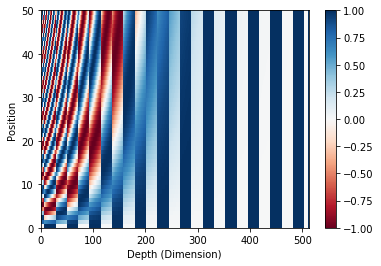

In [24]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap="RdBu")
plt.xlabel("Depth (Dimension)")
plt.xlim([0, 512])
plt.ylabel("Position")
plt.colorbar()
plt.show()

# Masking

## Padded Mask

Mask all pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where `pad` value 0 is present, it outputs a `1` at those locations, and a `0` otherwise. 

In [0]:
def create_padding_mask(seq):
  """
  Args:
    seq: (batch_size, sequence_length)

  Returns: (batc_size, 1, 1, sequence_length)
  """
  seq_ = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding information
  return seq_[:, tf.newaxis, tf.newaxis, :]

In [26]:
x = tf.constant([[7, 7, 0, 0, 1], [10, 20, 30, 0, 0], [0, 0, 0, 8, 9]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

## Look-ahead Mask

The `look-ahead` mask is used to mask the future tokens in a sequence. For example, to predict the third token only the first and the second token will be used.

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask # (seq_len, seq_len)

In [28]:
x = tf.random.uniform((1, 5))
create_look_ahead_mask(x.shape[1])

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

# Scaled Dot Product Attention

![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

Refer to Tensorflow.org (2020).

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculated the attention weights.
  q, k, v: have the same leading dimensions
  q, k: have the same last dimensions
  k, v: have the same penultimate dimension, for example, seq_len_k == seq_len_v
  mask: has different shapes depending on its type (padding or look head)

  Args:
    q (query): shape (..., seq_len_q, depth)
    k (key): shape (..., seq_len_k, depth)
    v (value): shape (..., seq_len_v, depth_v)
    mask: default is None,
          or Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)

  Returns:
    output, attention_weight
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  # prevent laftward

  # softmax is on the last axis (seq_len_k) so that the scores add up to 1
  attention_weight = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weight, v)  #(..., seq_len_q, seq_len_v)
  return output, attention_weight

After the softmax normalization is done on K, its value represents the amount of importance given to Q. In the end, the matrix multiplication represents the words you want to focus on are kept as-is and the irrelevant ones are flushed out.

In [0]:
def print_output_shape(q, k, v):
  temp_out, temp_weights = scaled_dot_product_attention(q, k, v, None)
  print("Output:", temp_out)
  print("Attention Weights:", temp_weights)

In [31]:
np.set_printoptions(suppress=True)

temp_K = tf.constant([[10, 0, 0, 0], 
                      [0, 10, 0, 0], 
                      [0, 0, 10, 0], 
                      [0, 0, 0, 10]], dtype=tf.float32)  # (1, 4, 4)

temp_V = tf.constant([[10, 1], 
                      [100, 10], 
                      [1000, 100], 
                      [10000, 1000]], dtype=tf.float32)  # (1, 4, 2)

temp_Q = tf.constant([[0, 0, 1, 0], 
                      [0, 1, 0, 0]], dtype=tf.float32)  # (1, 2, 4)

print_output_shape(temp_Q, temp_K, temp_V)

Output: tf.Tensor(
[[1046.9575    104.695755]
 [ 170.73361    17.07336 ]], shape=(2, 2), dtype=float32)
Attention Weights: tf.Tensor(
[[0.00660445 0.00660445 0.98018664 0.00660445]
 [0.00660445 0.98018664 0.00660445 0.00660445]], shape=(2, 4), dtype=float32)


Let's calculate step by step.

In [32]:
temp_QK = tf.matmul(temp_Q, temp_K, transpose_b=True)  # (1, 2, 4)
print(temp_QK.shape, temp_QK)

scaled_QK = temp_QK / tf.math.sqrt(tf.cast(tf.shape(temp_K)[-1], tf.float32))  # (1, 2, 4)
print(scaled_QK)

softmax_QK = tf.nn.softmax(scaled_QK, axis=-1)  # (1, 2, 4)
print(softmax_QK)

tf.matmul(softmax_QK.numpy(), temp_V)

(2, 4) tf.Tensor(
[[ 0.  0. 10.  0.]
 [ 0. 10.  0.  0.]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[0. 0. 5. 0.]
 [0. 5. 0. 0.]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[0.00660445 0.00660445 0.98018664 0.00660445]
 [0.00660445 0.98018664 0.00660445 0.00660445]], shape=(2, 4), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1046.9575  ,  104.695755],
       [ 170.73361 ,   17.07336 ]], dtype=float32)>

# Multi-Head Attention

![](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

Tensorflow.org (2020)

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_depth = d_model // num_heads

    self.wq = tf.keras.layers.Dense(units=d_model)
    self.wk = tf.keras.layers.Dense(units=d_model)
    self.wv = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_head(self, x, batch_size):
    x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.d_depth))

    # change to (batch_size, num_heads, seq_len, d_depth)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return x

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len_q, d_model)
    k = self.wk(k)  # (batch_size, seq_len_k, d_model)
    v = self.wv(v)  # (batch_size, seq_len_v, d_model)

    q = self.split_head(q, batch_size)  # (batch_size, num_heads, seq_len_q, d_depth)
    k = self.split_head(k, batch_size)  # (batch_size, num_heads, seq_len_k, d_depth)
    v = self.split_head(v, batch_size)  # (batch_size, num_heads, seq_len_v, d_depth)

    # output: (batch_size, num_heads, seq_len_q, seq_len_v == d_depth)
    #         seq_len_v == d_depth is from self.qv()
    # attention: (batch_size, num_heads, seq_len_q, seq_len_k)
    output, attention = scaled_dot_product_attention(q=q, k=k, v=v, mask=mask)

    # concatenation
    scaled_output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, d_depth)
    concat_output = tf.reshape(scaled_output, shape=(batch_size, -1, self.d_model))

    output = self.dense(concat_output)  # (batch_size, seq_len_q, d_model)
    return output, attention

Create a `MultiHeadAttention` layer to try out.

In [34]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
x = tf.random.uniform(shape=(10, 50, 256))  # (batch_size, seq_length, embedding + positional)
temp_outputs, temp_attentions = temp_mha(v=x, k=x, q=x, mask=None)

# temp_outputs: (batch_size=10, seq_len=50, d_model=512)
# temp_attentions: (batch_size=10, num_heads=8, seq_len_q=50, seq_len_k=50)
temp_outputs.shape, temp_attentions.shape

(TensorShape([10, 50, 512]), TensorShape([10, 8, 50, 50]))

# Point Wise Feed Forward Network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
    tf.keras.layers.Dense(units=dff, activation='relu'),
    tf.keras.layers.Dense(units=d_model)
  ])

In [36]:
point_wise = point_wise_feed_forward_network(d_model=512, dff=2048)
point_wise(tf.random.uniform(shape=(32, 64, 256))).shape   # (32, 64, 256) -> (32, 64, 512)

TensorShape([32, 64, 512])

# Encoder and Decoder

![](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

Tensorflow.org (2020)

## Encoder Layer

An encoder consists of two sublayers.
* A multi-head attention (with padded mask).
* A point-wise feed-forward network.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)

    self.dropout1 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)    

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, training, mask):
    """
    x: (batch_size, seq_len_q, d_model) over positional encoding
    """
    mha_output, _ = self.mha(v=x, k=x, q=x, mask=mask)  # (batch_size, seq_len_q, d_model)
    dropout_output1 = self.dropout1(mha_output, training=training)
    output1 = self.layernorm1(x + dropout_output1)  # (batch_size, seq_len_q, d_model)

    ffn_output = self.ffn(output1)
    dropout_output2 = self.dropout2(ffn_output, training=training)
    output2 = self.layernorm2(output1 + dropout_output2)  # (batch_size, seq_len_q, d_model)
    
    return output2

In [38]:
temp_encoder_layer = EncoderLayer(512, 8, 2048, 0.1)
temp_encoder_layer_output = temp_encoder_layer(
  tf.random.normal(shape=(32, 36, 512)), training=False, mask=None  # (batch_size=32, seq_len_q=36, d_model=512)
)
temp_encoder_layer_output.shape

TensorShape([32, 36, 512])

## Decoder Layer

A decoder layer consists of three sublayers.
* A masked multi-head attention layer (with a padded mask and a look ahead mask).
* A multi-head attention layer (with a padded mask).
* A point-wise feed-forward network.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.dropout1 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)
    self.dropout3 = tf.keras.layers.Dropout(rate=dropout_rate)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, encoder_output, training, look_ahead_mask, padded_mask):
    # x: (batch_size, seq_len_q, d_model)
    # encoder_output: (batch_size, seq_len_q, d_model)

    # mha1_output: (batch_size, seq_len_q, d_model)
    # mha1_attention: (batch_size, num_heads, seq_len_q, seq_len_k)
    mha1_output, mha1_attention = self.mha1(v=x, k=x, q=x, mask=look_ahead_mask)
    mha1_dropout = self.dropout1(mha1_output, training=training)
    output1 = self.layernorm1(x + mha1_dropout)  # (batch_size, seq_len_q, d_model)     

    # mha2_output: (batch_size, seq_len_q, d_model)
    # mha2_attention: (batch_size, num_heads, seq_len_q, seq_len_q)
    mha2_output, mha2_attention = self.mha2(
      v=encoder_output, k=encoder_output, q=output1, mask=padded_mask)
    mha2_dropout = self.dropout2(mha2_output, training=training)
    output2 = self.layernorm2(output1 + mha2_dropout)  # (batch_size, seq_len_q, d_model)

    ffn_output = self.ffn(output2)  # (batch_size, seq_len_q, d_model)
    ffn_dropout = self.dropout3(ffn_output, training=training)
    output3 = self.layernorm3(output2 + ffn_dropout)  # (batch_size, seq_len_q, d_model)

    return output3, mha1_attention, mha2_attention

In [40]:
temp_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
temp_deocder_layer_output, temp_mha1_attn, temp_mha2_attn = temp_decoder_layer(
  x = tf.random.normal(shape=(32, 36, 512)),
  encoder_output = temp_encoder_layer_output,
  training=False,
  look_ahead_mask=None,
  padded_mask=None
)

"""
temp_deocder_layer_output: (batch_size=32, seq_len_q=30, d_model=512)
temp_mha1_attn: (batch_size=32, num_heads=8, seq_len_q=30, seq_len_k=30)
temp_mha2_attn: (batch_size=32, num_heads=8, seq_len_q=30, seq_len_q=30)
"""
temp_deocder_layer_output.shape, temp_mha1_attn.shape, temp_mha2_attn.shape

(TensorShape([32, 36, 512]),
 TensorShape([32, 8, 36, 36]),
 TensorShape([32, 8, 36, 36]))

**The attention weights in the decoder layer are focusing on itself (the button layer, the look-ahead mask), and focusing on the encoder output (the upper layer, the padded mask).**

## Encoder

An encoder consists of:
* Input Embedding
* Positional Encoding
* N Encoder layers

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               max_positional_encoding, dropout_rate=0.1):
    """
    Args:
      num_heads: the number of heads
      d_model: the dimension of multi-heads, fnn, embedding layer, positional encoding
      dff: the dimension in point wise feed forwaed network
      input_vocab_size: the vocab size of subwords for word embedding
      max_positional_encoding: the max number of the sequence length
      dropout_rate: for the dropout layer
    """
    super(Encoder, self).__init__()

    self.embedding = tf.keras.layers.Embedding(
        input_dim=input_vocab_size, output_dim=d_model)
    self.positions = positional_encoding(
        position=max_positional_encoding, d_model=d_model)
    self.encoders = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) \
                     for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    # used in the call function
    self.d_model = d_model
    self.num_layers = num_layers

  def call(self, x, training, mask):
    """
    Args:
      x: the input in shape (batch_size, seq_len)
      training: True ot False
      mask: the padded mask
    Returns:
      outputs: the input of the decoder in shape (batch_size, x_seq_len, d_model)
    """
    embedding = self.embedding(x)  # (batch_size, x_seq_len, d_model)
    # scaled the embedding value for adding positional encoding
    embedding *= tf.sqrt(tf.cast(self.d_model, tf.float32))

    # get the sequence length for positional encoding
    input_seq_len = tf.shape(x)[1]
    pos_embed = embedding + self.positions[:, :input_seq_len, :]

    pos_embed = self.dropout(pos_embed, training=training)
    x_ = pos_embed

    # N x EncoderLayers
    for idx in range(self.num_layers):
      x_ = self.encoders[idx](x_, training, mask)

    return x_  # (batch_size, x_seq_len, d_model)

In [42]:
simple_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                         input_vocab_size=tokenizer_pt.vocab_size, 
                         max_positional_encoding=10000)

# generate the example batch input sequences
temp_input = tf.random.uniform(shape=(64, 62), dtype=tf.int64, minval=0, maxval=200)

encoder_output = simple_encoder(temp_input, training=False, mask=None)
encoder_output.shape  # (batch_size=64, seq_len=62, d_model=512)

TensorShape([64, 62, 512])

## Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               max_positional_encoding, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.embedding = tf.keras.layers.Embedding(input_dim=target_vocab_size, output_dim=d_model)
    self.positions = positional_encoding(position=max_positional_encoding, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
    self.decoders = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) \
                     for _ in range(num_layers)]

    # for the function call
    self.num_layers = num_layers
    self.d_model = d_model

  def call(self, x, encoder_output, training, look_ahead_mask, mask):
    """
    Args:
      x: the target, here is English, in shape (batch_size, seq_len)
      encoder_output: the encoder output in shape (batch_size, encoder_input_seq_len, d_model)
      training: True or False
      look_ahead_mask: (batch_size, seq_len, seq_len)
      mask: the padded mask in shape (batch_size, 1, 1, decoder_input_seq_len)

    Returns:
      output: the decoder output in shape (batch_szie, decoder_input_seq_len, d_model)
      attentions: a dictionary for two stage attention weights
    """
    attentions = {}   # for returns

    embed = self.embedding(x)  # (batch_size, seq_len, d_model)
    embed *= tf.sqrt(tf.cast(self.d_model, tf.float32))  # scaled for adding positional encoding

    # add the positional information
    input_seq_len = tf.shape(x)[1]
    pos_embed = embed + self.positions[:, :input_seq_len, :]

    x_ = self.dropout(pos_embed, training=training)

    # decoder layers
    for idx in range(self.num_layers):
      x_, attn1, attn2 = self.decoders[idx](x_, encoder_output=encoder_output, 
                                            training=training, 
                                            look_ahead_mask=look_ahead_mask, 
                                            padded_mask=mask)
      attentions['decoder_layer{}_block1'.format(idx)] = attn1
      attentions['decoder_layer{}_block2'.format(idx)] = attn2

    return x_, attentions

In [44]:
simple_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                         target_vocab_size=tokenizer_en.vocab_size, 
                         max_positional_encoding=10000)

temp_decoder_input = tf.random.uniform(shape=(64, 68), minval=0, maxval=200)
outputs, attentions = simple_decoder(x=temp_decoder_input, 
                                     encoder_output=encoder_output, 
                                     training=False, 
                                     look_ahead_mask=None, 
                                     mask=None)

print(outputs.shape)  # (batch_size=64, decoder_input_seq_len=68, d_model=512)
for key, val in attentions.items():
  print("Key: {}, shape: {}".format(key, val.shape))

(64, 68, 512)
Key: decoder_layer0_block1, shape: (64, 8, 68, 68)
Key: decoder_layer0_block2, shape: (64, 8, 68, 62)
Key: decoder_layer1_block1, shape: (64, 8, 68, 68)
Key: decoder_layer1_block2, shape: (64, 8, 68, 62)


# Create the Transformer

The Transformer consists of:
* An encoder
* A decoder
* A final linear layer 

The overall workflow is:
* The encoder takes the Portuguese subwords as the input and returns the subword encoding matrix as the output.
* The decoder takes the encoder output and the English subwords as the inputs and returns three matrixes. One is the decoder encoding matrix which is regarded as the decoder output. The second is the attention matrix for mapping English to English. The final is another attention matrix for mapping Portuguese to English.
* The final step is that the linear layer takes the decoder output to generate the logits for each subword.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, 
               input_vocab_size, target_vocab_size, 
               input_pos_enc, target_pos_enc, dropout_rate=0.1):
    """
    Args:
      num_layers: the number of layers stacked in the encoder and the decoder
      d_model: the dimension of representation used in the encoder and the decoder
      num_heads: how many splited heads
      dff: the dimension of point-wise feed forard network used in the encoder an the decoder
      input_vocab_size: for creating an embedding layer in the encoder
      target_vocab_size: for creating an embedding layer in the decoder
      input_pos_enc: the max position for encoding
      target_pos_enc: tha max position for decoding
      dropout_rate: the rate for the Dropout layer
    """
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, 
                           dff=dff, input_vocab_size=input_vocab_size, 
                           max_positional_encoding=input_pos_enc,
                           dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, 
                           dff=dff, target_vocab_size=target_vocab_size, 
                           max_positional_encoding=target_pos_enc,
                           dropout_rate=dropout_rate)
    # the final layer generates the subword probabilities of the target language
    self.final_layer = tf.keras.layers.Dense(units=target_vocab_size)

  def call(self, inputs, targets, training, 
           enc_padding_mask, look_ahead_mask, dec_padding_mask):
    """
    Args:
      inputs: the subword list created from the Portuguese text
      targets: the subword list created from the English text
      training: True or False
      enc_padding_mask: the padded mask used in the encoder
      look_ahead_mask: the look-ahead mask used in the 
                       button multi-head attenation of the decoder
      dec_padding_mask: the padded mask used in the 
                        upper multi-head attention of the decoder

    Returns:
      final_output: (batch_size, target_seq_length, target_vocab_size)
      attentions: a dictionary keeps the attentions of blocks in each decoder layer
    """
    # enc_output: (batch_size, inputs_seq_length, d_model)
    enc_output = self.encoder(inputs, training=training, mask=enc_padding_mask) 

    # dec_output: (batch_size, target_seq_length, d_model)
    dec_output, attentions = self.decoder(targets, encoder_output=enc_output, 
                                          training=training, 
                                          look_ahead_mask=look_ahead_mask, 
                                          mask=dec_padding_mask)

    # final_output: (batch_size, target_seq_length, target_vocab_size)
    final_output = self.final_layer(dec_output)

    return final_output, attentions

In [46]:
simple_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                                 input_vocab_size=tokenizer_pt.vocab_size + 2, 
                                 target_vocab_size=tokenizer_en.vocab_size + 2,
                                 input_pos_enc=10000, target_pos_enc=6000)

temp_input = tf.random.uniform(shape=(64, 70), minval=0, maxval=200, dtype=tf.int32)
temp_target = tf.random.uniform(shape=(64, 68), minval=0, maxval=200, dtype=tf.int32)

final_output, attentions = simple_transformer(
    inputs=temp_input, targets=temp_target, training=False, 
    enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None)

print(final_output.shape)
for key, val in attentions.items():
  print("Key: {}, Val shape: {}".format(key, val.shape))

(64, 68, 8089)
Key: decoder_layer0_block1, Val shape: (64, 8, 68, 68)
Key: decoder_layer0_block2, Val shape: (64, 8, 68, 70)
Key: decoder_layer1_block1, Val shape: (64, 8, 68, 68)
Key: decoder_layer1_block2, Val shape: (64, 8, 68, 70)


# Set the Hyperparameters

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

# Customized Optimizer

Use the Adam optimizer with $\beta_1 = 0.9$, $\beta_2 = 0.98$, and $\epsilon=10^{-9}$. The learning rate scheduler follows the formula.

$$lrate = d^{-0.5}_{model} * min(step\_num^{-0.5}, step\_num * warmup\_steps^{-1.5})$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_step=4000):
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_step = warmup_step
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_step ** (-1.5))
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model=d_model, warmup_step=4000)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

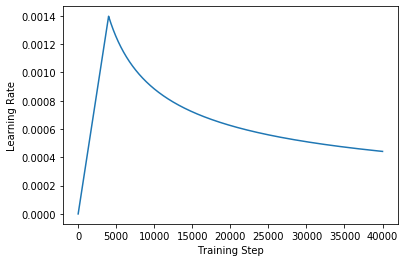

In [50]:
simple_lr = CustomSchedule(d_model=d_model)

plt.plot(simple_lr(tf.range(40000, dtype=tf.float32)))
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.show()

# Loss and Metrics

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
  from_logits=True, reduction='none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # real: (batch_size, seq_length)
  # pred: (batch_size, seq_length, target_vocab_size)
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  return tf.reduce_mean(loss)

In [0]:
#train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# Training and Checkpointing

In [0]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, 
                          num_heads=num_heads, dff=dff, 
                          input_vocab_size=input_vocab_size, 
                          target_vocab_size=target_vocab_size,
                          input_pos_enc=10000, target_pos_enc=8000,
                          dropout_rate=dropout_rate)

## Create all Masks

In [0]:
def create_mask(inputs, targets):
  # create the padding mask fot the encoder
  enc_padding_mask = create_padding_mask(inputs)

  # create the padding mask for the decoder
  # this mask is used on the upper multi-head attentions
  #
  # this mask is used to mask the encoder output
  dec_padding_mask = create_padding_mask(inputs)

  # create the look ahead mask for the decoder
  look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
  dec_target_padding_mask = create_padding_mask(targets)
  combined_mask = tf.math.maximum(look_ahead_mask, dec_target_padding_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
for pt, en in train_dataset.take(1):
  enc_padding_mask, combined_mask, dec_target_padding_mask = create_mask(pt[:1], en[:1])

In [56]:
enc_padding_mask, combined_mask, dec_target_padding_mask

(<tf.Tensor: shape=(1, 1, 1, 40), dtype=float32, numpy=
 array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 1, 40), dtype=float32, numpy=
 array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>)

Create the checkpoint and its manager to save it every `n` epochs.

In [0]:
saving_path = "/content/gdrive/My Drive/tmp/model_saving/"
assert os.path.exists(saving_path)

In [58]:
ckpt_path = os.path.join(saving_path, "ckpts", "train")

ckpt = tf.train.Checkpoint(transformer=transformer, 
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, 
                                          directory=ckpt_path, 
                                          max_to_keep=5)

# restore the checkpoint if it exists
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored.")

Latest checkpoint restored.


The target is divided into `target_input` and `target_real`. The `target_input` is passed as the input to the decoder. The `target_real` is the same input shifted by 1 to represent next token that should be predicted.

For example, 
* The `target` string is `SOS Transformer is awesome EOS`.
* The `target_input` string is `SOS Transformer is awesome`.
* The `target_real` string is `Transformer is awesome EOS`.

Train the transformer using `teacher-forcing`. The teacher-forcing is to pass the correct token to the next step regardless of what the output model predicts.

As the transformer predicts each word, it is allowed to look at the previous words of the input sequence to make the prediction. However, it is not allowed to peak at the expected output token using a `look-ahead mask`.


In [0]:
train_step_signature = [
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # input shape: (batch_size, seq_len)
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # target shape: (batch_size, seq_len)
]

@tf.function(input_signature=train_step_signature)
def train_step(inputs, targets):
  targets_input = targets[:, :-1]
  targets_real = targets[:, 1:]

  enc_padding_mask, look_ahead_mask, dec_target_padding_mask = create_mask(
    inputs=inputs, targets=targets_input)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inputs=inputs, 
                                 targets=targets_input,
                                 training=True,
                                 enc_padding_mask=enc_padding_mask, 
                                 look_ahead_mask=look_ahead_mask, 
                                 dec_padding_mask=dec_target_padding_mask)
    
    loss = loss_function(targets_real, predictions)

  # calculate the gradients and apply them to trainable variables
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  # update the loss and accuracy of the batch data
  train_loss(loss)
  train_accuracy(targets_real, predictions)

Complete the training process.

In [60]:
EPOCHS = 20
peroid = 0

for epoch in range(EPOCHS):
  peroid = time.time()

  # reset the statue
  train_loss.reset_states()
  train_accuracy.reset_states()

  # inputs: Portuguese, targets: English
  for batch, (inputs, targets) in enumerate(train_dataset):
    train_step(inputs, targets)

    if batch % 100 == 0:
      print("Epoch {}, Batch {}, Loss {:.6f}, Accuracy {:.6f}".format(
        epoch + 1, batch, train_loss.result(), train_accuracy.result()
      ))

  # save the model  
  if (epoch + 1) % 5 == 0:
    ckpt_manager.save()
    print("Save the checkpoint at epoch {}.".format(epoch + 1))

  # output the training status every epoch
  print("Epoch {}, Loss {:.4f}, Accuracy {:.4f}".format(
    epoch + 1, train_loss.result(), train_accuracy.result()
  ))

  print("Epoch took {} seconds.\n".format(time.time() - peroid))

Epoch 1, Batch 0, Loss 0.539906, Accuracy 0.404561
Epoch 1, Batch 100, Loss 0.499675, Accuracy 0.351140
Epoch 1, Batch 200, Loss 0.508204, Accuracy 0.351296
Epoch 1, Batch 300, Loss 0.512338, Accuracy 0.349210
Epoch 1, Batch 400, Loss 0.517269, Accuracy 0.348317
Epoch 1, Batch 500, Loss 0.524019, Accuracy 0.348878
Epoch 1, Batch 600, Loss 0.530846, Accuracy 0.348081
Epoch 1, Batch 700, Loss 0.536478, Accuracy 0.347152
Epoch 1, Loss 0.5364, Accuracy 0.3471
Epoch took 225.45778822898865 seconds.

Epoch 2, Batch 0, Loss 0.461608, Accuracy 0.360268
Epoch 2, Batch 100, Loss 0.484455, Accuracy 0.358922
Epoch 2, Batch 200, Loss 0.491012, Accuracy 0.356313
Epoch 2, Batch 300, Loss 0.495940, Accuracy 0.354426
Epoch 2, Batch 400, Loss 0.503505, Accuracy 0.354194
Epoch 2, Batch 500, Loss 0.507877, Accuracy 0.353044
Epoch 2, Batch 600, Loss 0.513726, Accuracy 0.352131
Epoch 2, Batch 700, Loss 0.519245, Accuracy 0.350767
Epoch 2, Loss 0.5193, Accuracy 0.3508
Epoch took 69.7679214477539 seconds.

Ep

# Evaluate

The following steps are used in the evaluation.
* Encode the input string using Portuguese tokenizer. Add the start token (`tokenizer_pt.vocabz_size`) and the end token (`tokenizer_pt.vocab_size + 1`) to the encoded string at the head and the end of the string.
* The decoder input is only the start token (`tokenizer_en.vocab_size`).
* Calculate the `look_ahead_mask` and the `padding_mask`.
* The `decoder` then outputs the predictions by looking at the encoder output and its own output.
* `Concatenate` the predicted token to the decoder input and pass it to the decoder for the next token.

In [0]:
def evaluate(inputs):
  """
  Args:
    inputs shape: a sentence in string
  """

  # encoder
  encoder_start = [tokenizer_pt.vocab_size]
  encoder_end = [tokenizer_pt.vocab_size + 1]
  encoder_inputs = encoder_start + tokenizer_pt.encode(inputs) + encoder_end
  encoder_inputs = tf.expand_dims(encoder_inputs, axis=0)    # (batch_size == 1, encoder_list_len)

  # decoder
  outputs = [tokenizer_en.vocab_size]
  outputs = tf.expand_dims(outputs, axis=0)  # (batch_size == 1, 1)

  # continue predicting
  for i in range(MAX_LENGTH):
    # creating masks
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_mask(
      encoder_inputs, outputs)

    # get the final output
    # output shape: (batch_size == 1, outputs_len, target_vocab_size)
    out, attns = transformer(encoder_inputs, 
                             outputs, 
                             False, 
                             enc_padding_mask, 
                             look_ahead_mask, 
                             dec_padding_mask)
    
    # output_token shape: (batch_size, 1) => (batch_size, 1)
    output_token = tf.cast(tf.argmax(out[:, -1:, :], axis=-1), tf.int32)

    # check whether the prediction token is the end token
    # here the inputs size of batch must be 1
    if output_token == (tokenizer_en.vocab_size + 1):
      return tf.squeeze(outputs, axis=0), attns

    # append the token to the outputs and continue predicting
    # outputs shape: (outputs_shape, )
    outputs = tf.concat([outputs, output_token], axis=-1)

  return tf.squeeze(outputs, axis=0), attns

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  """
  Args:
    attention shape: (batch_size, num_heads, None, None)
  """
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.encode(sentence)
  # remove the axis of the batch size
  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention
    ax.matshow(attention[head][:-1, :], cmap="viridis")

    fontdicts = {'fontsize': 10}

    ax.set_xticks(range(len(sentence) + 2))  # inputs
    ax.set_yticks(range(len(result)))  # targets

    ax.set_ylim(len(result) - 1.5, 0.5)

    # set labels
    ax.set_xticklabels(
      ["<start>"] + [tokenizer_pt.decode([t]) for t in sentence] + ["<end>"],
      fontdict=fontdicts,
      rotation=90
    )

    ax.set_yticklabels(
      [tokenizer_en.decode([t]) for t in result if t < tokenizer_en.vocab_size],
      fontdict=fontdicts
    )

    ax.set_xlabel('head {}'.format(head + 1))

  plt.tight_layout()
  plt.show

In [0]:
def translate(sentence, plot=''):
  result, attns = evaluate(sentence)
  predicted_sentence = tokenizer_en.decode([t for t in result if t < tokenizer_en.vocab_size])

  print("Input: {}".format(sentence))
  print("Predicted: {}".format(predicted_sentence))

  if plot:
    plot_attention_weights(attns, sentence=sentence, result=result, layer="decoder_layer2_block2")

In [90]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted: this is a problem that we have to solve it , and this is a problem .
Real translation: this is a problem we have to solve .


In [92]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [93]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted: so i 'm going to really close with you some of a few magical things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted: this is the first book that i did in my own life .
Real translation: this is the first book i've ever done.


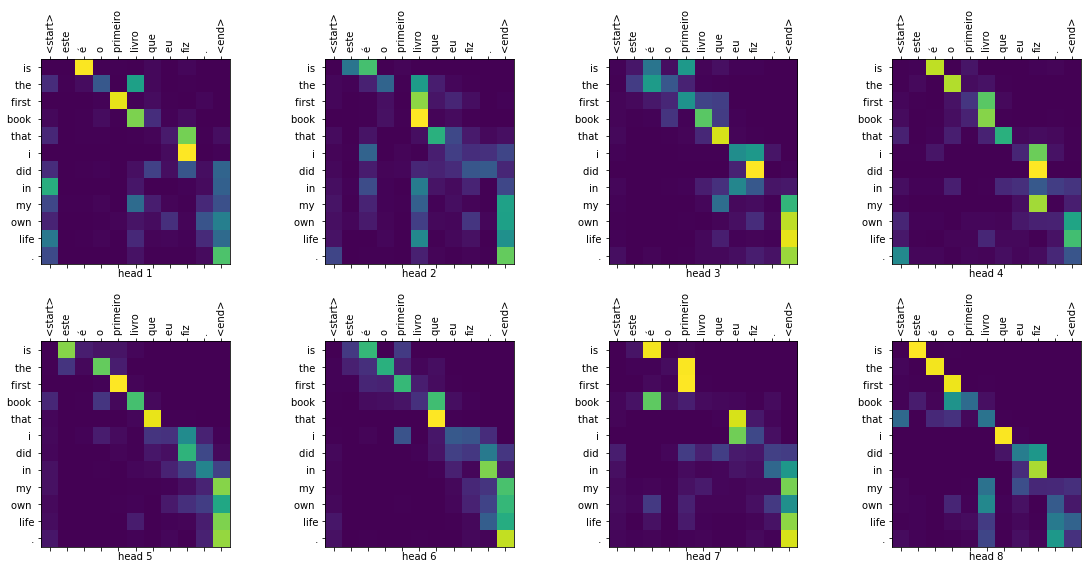

In [91]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")